In [59]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from pprint import pprint
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_context('notebook')
sns.set_style(style='darkgrid')
%matplotlib inline

In [60]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
#from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import NearMiss
#from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

In [61]:
def get_roc(y_test, y_pred):
    #Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristics')
    plt.legend(loc='upper left')
    plt.show()
    return



In [62]:
data = pd.read_csv('C:\Harinee\Projects\Capstone inference\Data\creditcard.csv')
data.head(10)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


(1) When doing the train/test split, it would be important
to preserver the proportion among the classes in
both sets.

In [63]:
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)


did the proportion is reflected in the split of 80 and 20

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123, shuffle=True)

In [65]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)

(4) If regularization is needed, it would be interesting to
see both L1 and L2 regularization (parameter 'penalty').

In [66]:
#This displays a sample confusion matrix and ROC
def analyzePredictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    #------------------------------
    drawConfusionMatrix(cnf_matrix)
    #-----------------------------------------
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    #------------------------------------------
    y_pred_proba = model.predict_proba(X_test)[:,1]
    get_roc(y_test, y_pred_proba)

In [68]:
def drawConfusionMatrix(cnf_matrix):
    print(cnf_matrix)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

Logistic Regression
[[56852    12]
 [   39    59]]


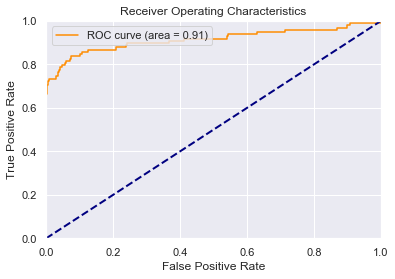

In [69]:
#Logistic Regression
#Use Logistic Regression using the train data, then compute the confusion matrix and the AUC.
from sklearn.linear_model import LogisticRegression
print ("Logistic Regression")
def logregclf(X_train, y_train, X_test, y_test):
    model = LogisticRegression(solver='lbfgs', max_iter=500, C=10).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    y_pred_proba = model.predict_proba(X_test)[:,1]
    get_roc(y_test, y_pred_proba)
    return
logregclf(X_train, y_train, X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[227362     89]
 [   124    270]]
Accuracy: 0.999065153942373
Precision: 0.7520891364902507
Recall: 0.6852791878172588


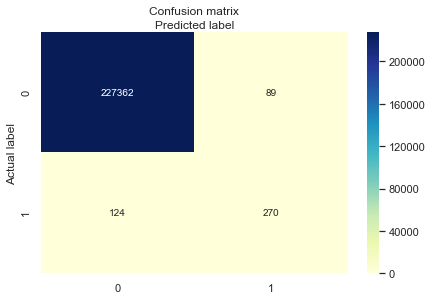

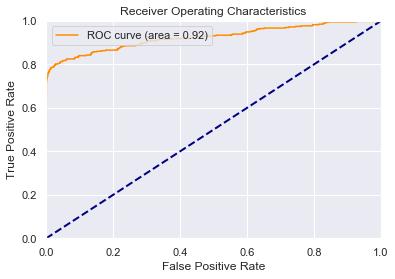

In [70]:
model = LogisticRegression()
model.fit(X_train,y_train)
analyzePredictions(model, X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[56844    20]
 [   39    59]]
Accuracy: 0.9989642217618764
Precision: 0.7468354430379747
Recall: 0.6020408163265306


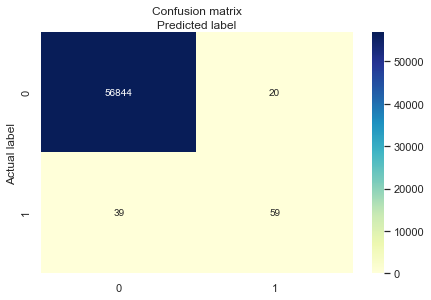

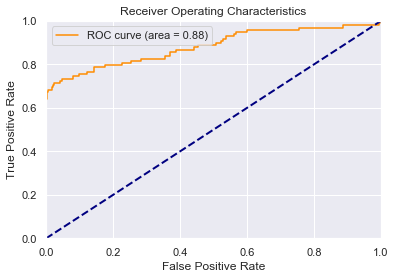

In [71]:
model = LogisticRegression()
model.fit(X_train,y_train)
analyzePredictions(model, X_test, y_test)

The Model is NOT overfitting. Still run Logistic Regression With A L1 Penalty With Various Regularization Strengths The usefulness of L1 is that it can push feature coefficients to 0, creating a method for feature selection. In the code below we run a logistic regression with a L1 penalty four times, each time decreasing the value of C. We should expect that as C decreases, more coefficients become 0.

In [110]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')

C: 10
Coefficient of each feature: [[-3.56393101e-06  8.34829154e-02 -2.01661964e-02 -1.30206921e-02
   6.56400030e-01  1.13755645e-01 -1.05011498e-01 -9.78680753e-02
  -1.67521030e-01 -3.57271213e-01 -8.22741982e-01 -4.90202880e-02
   3.30136713e-02 -2.79651418e-01 -5.57638276e-01 -1.13817209e-01
  -1.13121632e-01 -4.38573285e-02 -1.96680481e-02  1.15832006e-01
  -4.39077013e-01  4.17340837e-01  6.40899256e-01 -4.18797935e-02
   2.36471963e-01 -1.93312264e-01  4.81938677e-02 -8.42642024e-01
  -2.99753793e-01  7.51291740e-04]]
Training accuracy: 0.9985253132612083
Test accuracy: 0.9983497770443454

C: 1
Coefficient of each feature: [[-3.56047585e-06  7.03948020e-02 -2.06101128e-02 -1.29222497e-02
   6.38851269e-01  1.07279677e-01 -9.71562410e-02 -8.17676740e-02
  -1.70792057e-01 -3.39522363e-01 -7.85864680e-01 -3.64403430e-02
   8.49024198e-03 -2.64329102e-01 -5.53913162e-01 -1.07898798e-01
  -1.20956893e-01 -4.47919682e-02 -7.51670755e-03  1.04772952e-01
  -4.01267129e-01  4.02169721e

In [111]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l2', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')

C: 10
Coefficient of each feature: [[-8.94549492e-05  1.97945300e-01 -3.64664126e-01 -8.61960105e-01
   1.58735680e-01 -5.14909084e-02 -7.35502988e-02  9.86330941e-02
  -1.83581205e-01 -4.10982500e-01 -2.45477956e-01 -1.61185372e-01
  -6.15540679e-02 -2.69335138e-01 -7.85484105e-01 -2.71710949e-01
  -3.08136772e-01 -5.24778367e-01 -1.64287697e-02  6.07515605e-02
   6.17315951e-02  1.80028133e-01  2.27952593e-01  4.39481219e-02
  -2.99681458e-02 -2.06601237e-01  3.58380569e-02 -6.03006269e-02
   3.86275464e-02 -7.13067795e-03]]
Training accuracy: 0.8223485264104984
Test accuracy: 0.8215125873389277

C: 1
Coefficient of each feature: [[-8.94481317e-05  1.97857344e-01 -3.64574314e-01 -8.61712755e-01
   1.58700484e-01 -5.14609242e-02 -7.35311976e-02  9.86447918e-02
  -1.83550551e-01 -4.10825002e-01 -2.45395599e-01 -1.61130396e-01
  -6.15682961e-02 -2.69228594e-01 -7.85234636e-01 -2.71654640e-01
  -3.08031107e-01 -5.24579907e-01 -1.64030885e-02  6.07253278e-02
   6.17099745e-02  1.79975582e

So, Now number of coefficients with zero values is zero. So, now it is clear that Ridge regularisation (L2 Regularisation) does not shrink the coefficients to zero.

In [72]:
from sklearn.metrics import classification_report
y_predict_test = model.predict(X_test)
y_predict_training = model.predict(X_train)


In [73]:
print("[Training Classification Report]")
print(classification_report(y_train, y_predict_training))

print("[Test Classification Report]")
print(classification_report(y_test, y_predict_test))

[Training Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.75      0.69      0.72       394

   micro avg       1.00      1.00      1.00    227845
   macro avg       0.88      0.84      0.86    227845
weighted avg       1.00      1.00      1.00    227845

[Test Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.75      0.60      0.67        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.87      0.80      0.83     56962
weighted avg       1.00      1.00      1.00     56962



The classification report metrics are similar in training and Test and it is too good to be true. The reason being due to the imbalanced data set and hence it needs to be addressed.

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')


No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [55]:
from sklearn.metrics import classification_report, precision_score, f1_score, accuracy_score

In [75]:
from sklearn.metrics import classification_report, precision_score, f1_score, accuracy_score
def printScores(model, X_train, X_test, y_train, y_test):
    y_predict_test = model.predict(X_test)
    y_predict_training = model.predict(X_train)
    print("[Training Classification Report]")
    #print(classification_report(y_train, y_predict_training))
    print("Precision = ", precision_score(y_train, y_predict_training))
    print("Recall = ", recall_score(y_train, y_predict_training))
    print("F1 Score = ", f1_score(y_train, y_predict_training))

    print("")
    print("[Test Classification Report]")
    #print(classification_report(y_test, y_predict_test))
    print("Precision = ", precision_score(y_test, y_predict_test))
    print("Recall = ", recall_score(y_test, y_predict_test))
    print("F1 Score = ", f1_score(y_test, y_predict_test))
    return

In [76]:
printScores(model, X_train, X_test, y_train, y_test)

[Training Classification Report]
Precision =  0.7520891364902507
Recall =  0.6852791878172588
F1 Score =  0.7171314741035856

[Test Classification Report]
Precision =  0.7468354430379747
Recall =  0.6020408163265306
F1 Score =  0.6666666666666667


Dropping  Time


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[Training Classification Report]
MCC =  0.7603272238524483
Precision =  0.8975265017667845
Recall =  0.6446700507614214
F1 Score =  0.7503692762186115

[Test Classification Report]
MCC =  0.701248626771345
Precision =  0.8615384615384616
Recall =  0.5714285714285714
F1 Score =  0.6871165644171779
Dropping  V1
[Training Classification Report]
MCC =  0.7384124151280429
Precision =  0.8466666666666667
Recall =  0.6446700507614214
F1 Score =  0.7319884726224785

[Test Classification Report]
MCC =  0.664365315228303
Precision =  0.76
Recall =  0.5816326530612245
F1 Score =  0.6589595375722543
Dropping  V2
[Training Classification Report]
MCC =  0.7202443846977138
Precision =  0.8217821782178217
Recall =  0.631979695431472
F1 Score =  0.7144906743185078

[Test Classification Report]
MCC =  0.701953774854333
Precision =  0.8194444444444444
Recall =  0.6020408163265306
F1 Score =  0.6941176470588234
Dropping  V3
[Training Classification Report]
MCC =  0.7617170969299201
Precision =  0.87333333

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[Training Classification Report]
MCC =  0.7201981048580797
Precision =  0.8384879725085911
Recall =  0.6192893401015228
F1 Score =  0.7124087591240875

[Test Classification Report]
MCC =  0.6959005527982292
Precision =  0.8484848484848485
Recall =  0.5714285714285714
F1 Score =  0.6829268292682927
Dropping  V10
[Training Classification Report]
MCC =  0.7270352540307702
Precision =  0.8406779661016949
Recall =  0.6294416243654822
F1 Score =  0.7198838896952104

[Test Classification Report]
MCC =  0.6906725482238516
Precision =  0.835820895522388
Recall =  0.5714285714285714
F1 Score =  0.6787878787878787
Dropping  V11
[Training Classification Report]
MCC =  0.7417633441542574
Precision =  0.847682119205298
Recall =  0.649746192893401
F1 Score =  0.735632183908046

[Test Classification Report]
MCC =  0.7041351837035832
Precision =  0.8108108108108109
Recall =  0.6122448979591837
F1 Score =  0.6976744186046512
Dropping  V12
[Training Classification Report]
MCC =  0.7101022982917885
Precis

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[Training Classification Report]
MCC =  0.7421820357724104
Precision =  0.8655172413793103
Recall =  0.6370558375634517
F1 Score =  0.7339181286549707

[Test Classification Report]
MCC =  0.6805592531629351
Precision =  0.8115942028985508
Recall =  0.5714285714285714
F1 Score =  0.6706586826347305
Dropping  V15
[Training Classification Report]
MCC =  0.7446610723323503
Precision =  0.8610169491525423
Recall =  0.6446700507614214
F1 Score =  0.737300435413643

[Test Classification Report]
MCC =  0.7240316187047102
Precision =  0.8571428571428571
Recall =  0.6122448979591837
F1 Score =  0.7142857142857143
Dropping  V16
[Training Classification Report]
MCC =  0.7349686483312677
Precision =  0.8290322580645161
Recall =  0.6522842639593909
F1 Score =  0.7301136363636364

[Test Classification Report]
MCC =  0.699411245770977
Precision =  0.8
Recall =  0.6122448979591837
F1 Score =  0.6936416184971098
Dropping  V17
[Training Classification Report]
MCC =  0.746738681076433
Precision =  0.85906

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[Training Classification Report]
MCC =  0.7504736521070523
Precision =  0.8576158940397351
Recall =  0.6573604060913706
F1 Score =  0.7442528735632186

[Test Classification Report]
MCC =  0.6959005527982292
Precision =  0.8484848484848485
Recall =  0.5714285714285714
F1 Score =  0.6829268292682927
Dropping  V21
[Training Classification Report]
MCC =  0.7375333440751606
Precision =  0.8513513513513513
Recall =  0.6395939086294417
F1 Score =  0.7304347826086958

[Test Classification Report]
MCC =  0.7138763281769754
Precision =  0.8333333333333334
Recall =  0.6122448979591837
F1 Score =  0.7058823529411765
Dropping  V22
[Training Classification Report]
MCC =  0.7640984553972642
Precision =  0.8688524590163934
Recall =  0.6725888324873096
F1 Score =  0.7582260371959944

[Test Classification Report]
MCC =  0.6877572283181294
Precision =  0.8142857142857143
Recall =  0.5816326530612245
F1 Score =  0.6785714285714286
Dropping  V23
[Training Classification Report]
MCC =  0.7499229986837048
Pr

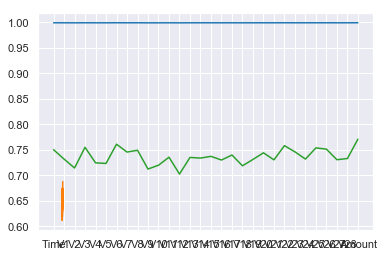

In [45]:
xAx=[]
accAx=[]
precAx=[]
recAx=[]
f1Ax=[]
for idx, val in enumerate(X_train.columns):
    print("Dropping ", val)
    model = LogisticRegression(solver='lbfgs', max_iter=500, C=10).fit(X_train, y_train)
    X_train_new = X_train.drop(val, axis=1)
    X_test_new = X_test.drop(val, axis=1)
    model.fit(X_train_new, y_train)
    printScores(model, X_train_new, X_test_new, y_train, y_test)
    y_predict_training = model.predict(X_train_new)
    xAx = np.append(xAx, val)
    accAx = np.append(accAx, accuracy_score(y_train, y_predict_training))
    precAx = np.append(precAx, precision_score(y_train, y_predict_training))
    recAx = np.append(recAx, recall_score(y_train, y_predict_training))
    f1Ax = np.append(f1Ax, f1_score(y_train, y_predict_training))
plt.plot(xAx, accAx, precAx, recAx, f1Ax)

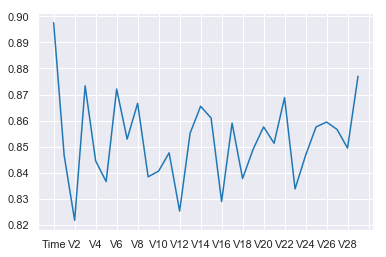

In [89]:
plt.xticks(list(range(0, 100,2))) 
plt.plot(xAx, precAx)

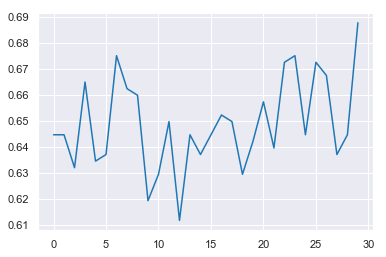

In [50]:
plt.plot(recAx)

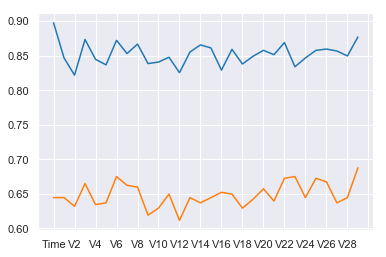

In [91]:
plt.xticks(list(range(0, 100,2))) 
plt.plot(xAx, precAx, recAx)

In [ ]:
#Random under-sampling:
count_class_0, count_class_1 = data.Class.value_counts()

# Divide by class
df_class_0 = df[df['Class'] == 0]
df_class_1 = df[df['Class'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Class.value_counts())
df_test_under.Class.value_counts().plot(kind='bar',title = 'count(Class)')

In [92]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [24]:
import imblearn

In [25]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus, id_rus = rus.fit_sample(X,y)

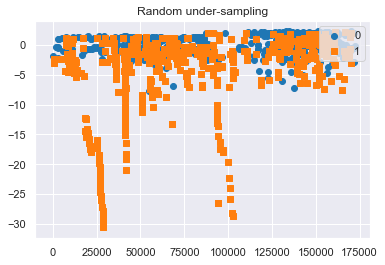

In [44]:
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

In [30]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

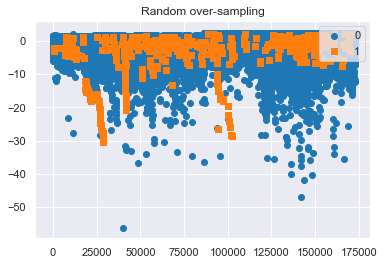

In [31]:
plot_2d_space(X_ros, y_ros, 'Random over-sampling')